# Exploratory Data Analysis


In [39]:
%matplotlib inline
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import quandl
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np

from statsmodels.graphics.gofplots import ProbPlot

plt.style.use('seaborn')# pretty matplotlib plots

plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)


In [3]:
wine = quandl.get("LIVEX/LVX_INV").rename(columns={'Value': 'Wine'})
cpi = quandl.get("FRED/CPIAUCSL").rename(columns={'Value': 'CPI'})
sp500 = quandl.get("MULTPL/SP500_REAL_PRICE_MONTH", authtoken="J4FzTxgHCWd2xFVDYbQM").rename(columns={'Value': 'S&P 500'})

In [4]:
cpi.head()

,CPI
Date,
1947-01-01,21.48
1947-02-01,21.62
1947-03-01,22.00
1947-04-01,22.00
1947-05-01,21.95


In [5]:
wine.tail()

,Wine
Date,
2017-10-31,337.91
2017-11-30,341.13
2017-12-31,341.28
2018-01-31,341.57
2018-02-28,341.22


In [6]:
sp500.tail()

,S&P 500
Date,
2018-03-01,2702.77
2018-04-01,2653.63
2018-05-01,2701.49
2018-06-01,2754.35
2018-07-01,2736.61


## Missing data due to misaligned join because data has either 01/01 or 01/31 monthly dates.

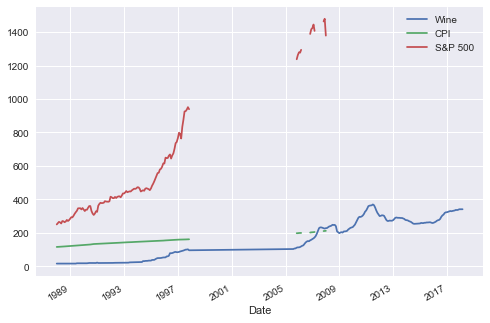

In [40]:
sns.set() #adds grey grid lines
wine.join(cpi).join(sp500).plot();

In [8]:
print("How many different days of the month?")
print("CPI: ", cpi.index.day.unique())
print("Wine ", wine.index.day.unique())
print("S&P 500 ", sp500.index.day.unique())

How many different days of the month?
CPI:  Int64Index([1], dtype='int64', name='Date')
Wine  Int64Index([1, 31, 30, 29, 28], dtype='int64', name='Date')
S&P 500  Int64Index([1], dtype='int64', name='Date')


In [42]:
# Need to align the indices
def nearest_month(dt):
    #either first or last day of month
    return dt if dt.is_month_start else dt + pd.offsets.Day(1)

In [43]:
cpimod = cpi.copy()
winemod = wine.copy()
sp500mod = sp500.copy()
cpimod.index = cpi.index.map(nearest_month)
winemod.index = wine.index.map(nearest_month)
sp500mod.index = sp500.index.map(nearest_month)
# Check is wine is modified
winemod.tail()

,Wine
Date,
2017-11-01,337.91
2017-12-01,341.13
2018-01-01,341.28
2018-02-01,341.57
2018-03-01,341.22


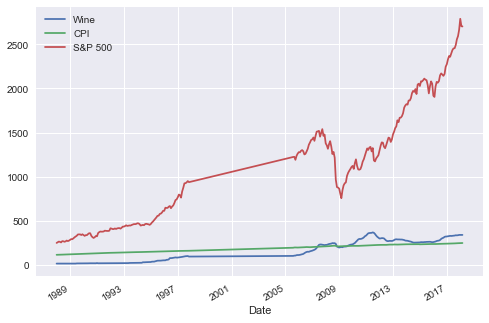

In [44]:
df = winemod.join(cpimod).join(sp500mod)
df.plot();

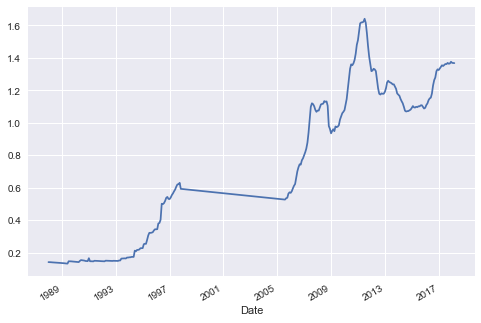

In [45]:
df["Wine_Over_CPI"]= df.Wine/df.CPI
df.Wine_Over_CPI.plot();

In [46]:
df.head()

,Wine,CPI,S&P 500,Wine_Over_CPI
Date,,,,
1988-01-01,16.54,116.0,250.5,0.142586
1988-02-01,16.54,116.2,258.1,0.142341
1988-03-01,16.54,116.5,265.7,0.141974
1988-04-01,16.54,117.2,262.6,0.141126
1988-05-01,16.54,117.5,256.1,0.140766


In [47]:
df.to_csv("Wine_CPI_S&P500.csv")

## Notice Wine strengthens over cpi after 2009 1.0 = even point; remember wine missing data 1998 - 2005

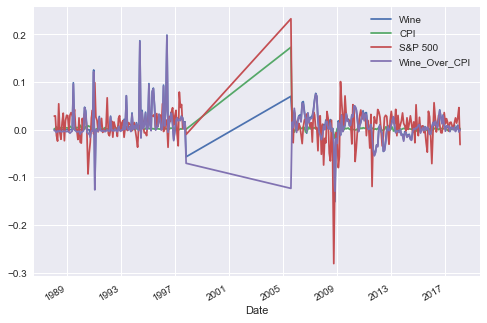

In [48]:
# Return = (value(now)-value(prev)) / value(prev)
df_returns = (df.diff()/df.shift(-1)).dropna()
df_returns.plot();

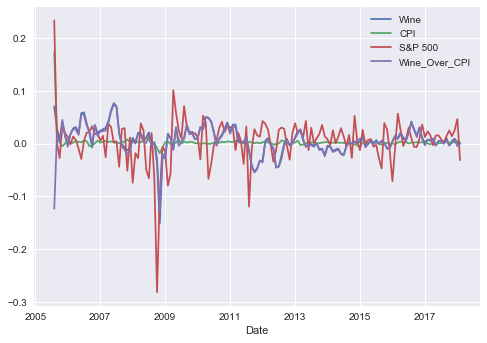

In [49]:
df_returns['2005':].plot()

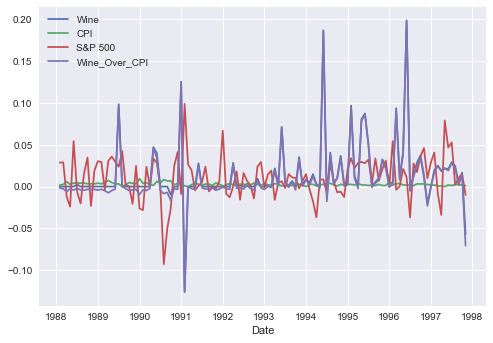

In [50]:
df_returns[:'1998'].plot()

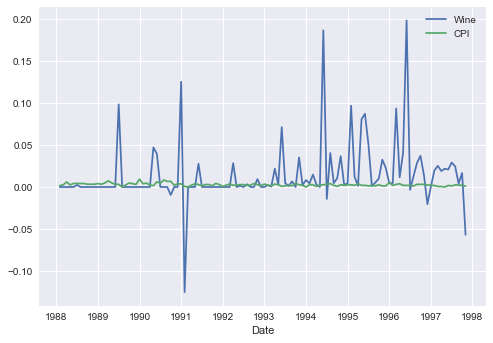

In [51]:
df_returns[['Wine','CPI']][:'1998'].plot()

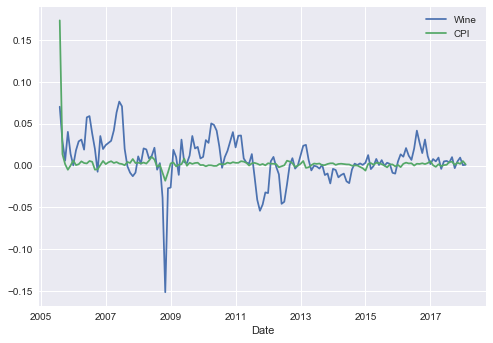

In [52]:
df_returns[['Wine','CPI']]['2005':].plot()

In [53]:
# import matplotlib as mpl
#def myFormatter(x, pos):
 #   return pd.to_datetime(x)

#fig, ax = plt.subplots()
#sns.tsplot(cpi.Value,time=cpi.index, ax=ax)
#ax.xaxis.set_major_locator(mdates.AutoDateLocator())
#ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(myFormatter))
#plt.show()

# Look at the time series dependency
Using autocorrelation plot determine how many lags to include in my regression. 


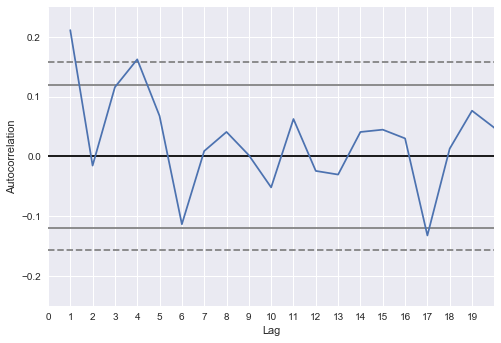

In [54]:
# PANDAS 
ax = pd.plotting.autocorrelation_plot(
    df_returns['S&P 500'],
    #grid=True,
    #xlim=(0,20),
    #xticks=range(20),
)
ax.set_xlim(0,20)# set parameters lag 1
ax.set_ylim(-.25,.25)
ax.set_xticks(range(20))
ax.set_xticklabels(range(20))
plt.grid(True);

# Results
Lag 1 and 4 are the only points outside the 99% confidence level
Justifies using them for the regression analysis to address time dependency
# Next steps
Make a dataframe that has the lags and make a regression model and show CPI and LXV regressed against S&P 500

In [55]:
cpi.index # checking to see if there's an issue

DatetimeIndex(['1947-01-01', '1947-02-01', '1947-03-01', '1947-04-01',
               '1947-05-01', '1947-06-01', '1947-07-01', '1947-08-01',
               '1947-09-01', '1947-10-01',
               ...
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01',
               '2018-07-01', '2018-08-01'],
              dtype='datetime64[ns]', name='Date', length=860, freq=None)

## Dates don't align, monthly
Dates for CPI are 1/1/2018
Dates for WINE are 1/31/2018
Solution: Shift one by a month so they are only one day apart. 

In [56]:
cpimod = cpi.reset_index()
cpimod.columns = "Date","CPI"
cpimod["Year"]= cpimod.Date.dt.year
cpimod["Month"]= cpimod.Date.dt.month
cpimod["Day"] = 1
cpimod["Rounded_Date"] = pd.to_datetime(cpimod[["Year", "Month", "Day"]])
cpimod["Joined_Column"] = 100*cpimod.Year + cpimod.Month
cpimod.head()


,Date,CPI,Year,Month,Day,Rounded_Date,Joined_Column
0,1947-01-01,21.48,1947,1,1,1947-01-01,194701
1,1947-02-01,21.62,1947,2,1,1947-02-01,194702
2,1947-03-01,22.00,1947,3,1,1947-03-01,194703
3,1947-04-01,22.00,1947,4,1,1947-04-01,194704
4,1947-05-01,21.95,1947,5,1,1947-05-01,194705


In [57]:
sp500mod = sp500.reset_index()
sp500mod.columns = "Date","S&P 500"
sp500mod["Year"]= sp500mod.Date.dt.year
sp500mod["Month"]= sp500mod.Date.dt.month
sp500mod["Day"] = 1
sp500mod["Rounded_Date"] = pd.to_datetime(sp500mod[["Year", "Month", "Day"]])
sp500mod["Joined_Column"] = 100*sp500mod.Year + sp500mod.Month
sp500mod.head()


,Date,S&P 500,Year,Month,Day,Rounded_Date,Joined_Column
0,1871-01-01,4.44,1871,1,1,1871-01-01,187101
1,1871-02-01,4.50,1871,2,1,1871-02-01,187102
2,1871-03-01,4.61,1871,3,1,1871-03-01,187103
3,1871-04-01,4.74,1871,4,1,1871-04-01,187104
4,1871-05-01,4.86,1871,5,1,1871-05-01,187105


In [58]:
winemod = wine.reset_index()
winemod.columns = "Date", "LVX"
winemod["Year"]= winemod.Date.dt.year
winemod["Month"]= winemod.Date.dt.month
winemod["Day"] = 1
winemod["Rounded_Date"] =pd.to_datetime(winemod[["Year", "Month", "Day"]])
winemod["Joined_Column"] = 100*winemod.Year + winemod.Month
#winemod["Shift_Date"]= winemod.Date datetime.timedelta(days = 1)
winemod.head()

,Date,LVX,Year,Month,Day,Rounded_Date,Joined_Column
0,1988-01-01,16.54,1988,1,1,1988-01-01,198801
1,1988-02-01,16.54,1988,2,1,1988-02-01,198802
2,1988-03-01,16.54,1988,3,1,1988-03-01,198803
3,1988-04-01,16.54,1988,4,1,1988-04-01,198804
4,1988-05-01,16.54,1988,5,1,1988-05-01,198805


In [59]:
#df = winemod[["Rounded_Date", "Joined_Column","LVX"]].join(cpimod[["Joined_Column", "CPI"]],on=["Joined_Column"])
df = pd.concat([winemod[["Rounded_Date", "Joined_Column","LVX"]],
                cpimod[["Joined_Column", "CPI"]],
                sp500mod[["Joined_Column", "S&P 500"]]],
              axis=1, join='inner', ignore_index=True)
df.columns = ["Rounded_Date", "Joined_Column_1","LVX",
              "Joined_Column_2", "CPI",
             "Joined_Column_3", "S&P 500"]
df.drop(labels=["Joined_Column_1", "Joined_Column_2", "Joined_Column_3"], inplace=True, axis=1)
df.set_index("Rounded_Date", inplace=True)
df.head()
df.tail()

,LVX,CPI,S&P 500
Rounded_Date,,,
2017-10-01,337.91,36.1,5.31
2017-11-01,341.13,36.3,5.31
2017-12-01,341.28,36.4,4.84
2018-01-01,341.57,36.6,4.61
2018-02-01,341.22,36.8,4.18


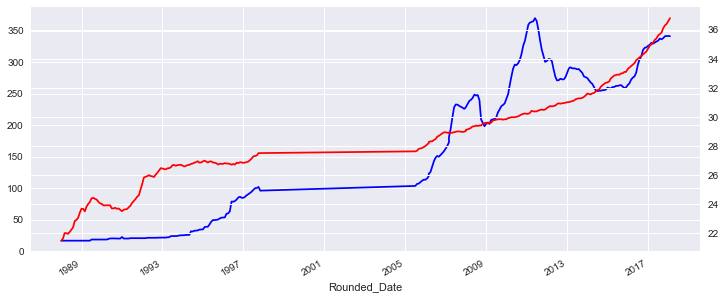

In [60]:
plt.figure(figsize=(12,5))
ax1 = df.LVX.plot(color='blue', grid=True)
ax2 = df.CPI.plot(color='red', grid=True, secondary_y=True)
plt.show()
        

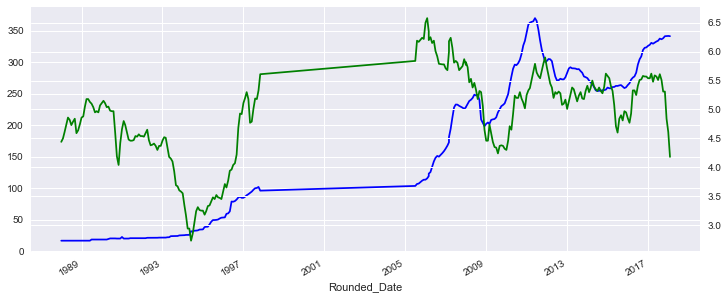

In [61]:
#sp500 = quandl.get("MULTPL/SP500_REAL_PRICE_MONTH", authtoken="J4FzTxgHCWd2xFVDYbQM")
plt.figure(figsize=(12,5))
ax1 = df.LVX.plot(color='blue', grid=True)
ax2 = df['S&P 500'].plot(color='green', grid=True, secondary_y=True)
plt.show()


# Hard to see the timeline zoom due to missing data 1998-2005
This next section shows the returns without the missing data

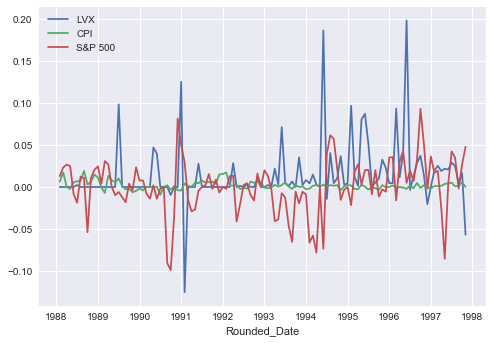

In [62]:
df_newreturns = (df.diff()/df.shift(-1)).dropna()
df_newreturns[:'1998'].plot();

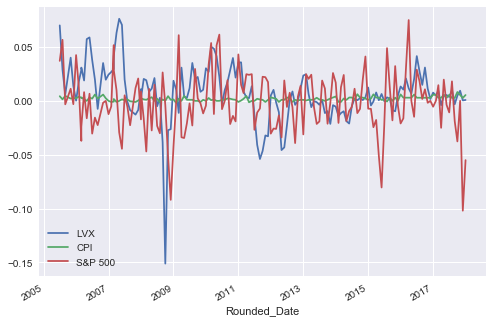

In [63]:
df_newreturns['2005':].plot();

# Now we are at a point to use the lag 1 & 4 we identified in the auto-correlation
We will make a regression of the S&P 500, CPI, LVX against lags 1 & 4 of S&P 500

In [64]:
df = df.rename(columns={"S&P 500": "SP500"})
df.head()

,LVX,CPI,SP500
Rounded_Date,,,
1988-01-01,16.54,21.48,4.44
1988-02-01,16.54,21.62,4.50
1988-03-01,16.54,22.00,4.61
1988-04-01,16.54,22.00,4.74
1988-05-01,16.54,21.95,4.86


In [65]:
df = df.assign(SP500_lag1=df.SP500.shift(1))
df = df.assign(SP500_lag4=df.SP500.shift(4))
df.head()

,LVX,CPI,SP500,SP500_lag1,SP500_lag4
Rounded_Date,,,,,
1988-01-01,16.54,21.48,4.44,NaN,NaN
1988-02-01,16.54,21.62,4.50,4.44,NaN
1988-03-01,16.54,22.00,4.61,4.50,NaN
1988-04-01,16.54,22.00,4.74,4.61,NaN
1988-05-01,16.54,21.95,4.86,4.74,4.44


# Want to exclude missing range of data 1998-2005
redo this exact thing for all three indexes

In [78]:
keep = df.dropna()
formula = 'CPI ~ SP500_lag1 + SP500_lag4'
cpi_model = smf.ols(formula=formula, data=keep).fit()
cpi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CPI   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     27.85
Date:                Sun, 30 Sep 2018   Prob (F-statistic):           1.06e-11
Time:                        10:58:39   Log-Likelihood:                -674.62
No. Observations:                 267   AIC:                             1355.
Df Residuals:                     264   BIC:                             1366.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     19.8618      1.211     16.400      0.000      17.477      22.246
SP500_lag1     0.1420      0.654      0.217      0.828      -1.146       1.430
SP500_lag4     1.6532      0.654      2.529      0.012       0.366       2.940
==============================================================================
Omnibus:                        4.707   Durbin-Watson:                   0.007
Prob(Omnibus):                  0.095   Jarque-Bera (JB):                2.984
Skew:                           0.012   Prob(JB):                        0.225
Kurtosis:                       2.483   Cond. No.                         46.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Interpretation
R-squared isn't close to 1, actual is .174

In [79]:
keep = df.dropna()
formula = 'CPI ~ SP500_lag1 + SP500_lag4 - 1' #remove the intercept
cpi_model = smf.ols(formula=formula, data=keep)
model_fit = cpi_model.fit()
model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CPI   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     5835.
Date:                Sun, 30 Sep 2018   Prob (F-statistic):          8.01e-220
Time:                        10:58:47   Log-Likelihood:                -768.41
No. Observations:                 267   AIC:                             1541.
Df Residuals:                     265   BIC:                             1548.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
SP500_lag1     2.1616      0.911      2.373      0.018       0.368       3.955
SP500_lag4     3.5822      0.912      3.928      0.000       1.787       5.378
==============================================================================
Omnibus:                       13.745   Durbin-Watson:                   0.018
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                6.206
Skew:                           0.100   Prob(JB):                       0.0449
Kurtosis:                       2.281   Cond. No.                         34.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Interpretation
R-squared is closer to 1
P value is less than .05 likely that both coefficients are relevant in the model, both positive.

https://medium.com/@emredjan/emulating-r-regression-plots-in-python-43741952c034


In [80]:
# fitted values (need a constant term for intercept)
model_fitted_y = model_fit.fittedvalues

# model residuals
model_residuals = model_fit.resid

# normalized residuals
model_norm_residuals = model_fit.get_influence().resid_studentized_internal

# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

# absolute residuals
model_abs_resid = np.abs(model_residuals)

# leverage, from statsmodels internals
model_leverage = model_fit.get_influence().hat_matrix_diag

# cook's distance, from statsmodels internals
model_cooks = model_fit.get_influence().cooks_distance[0]

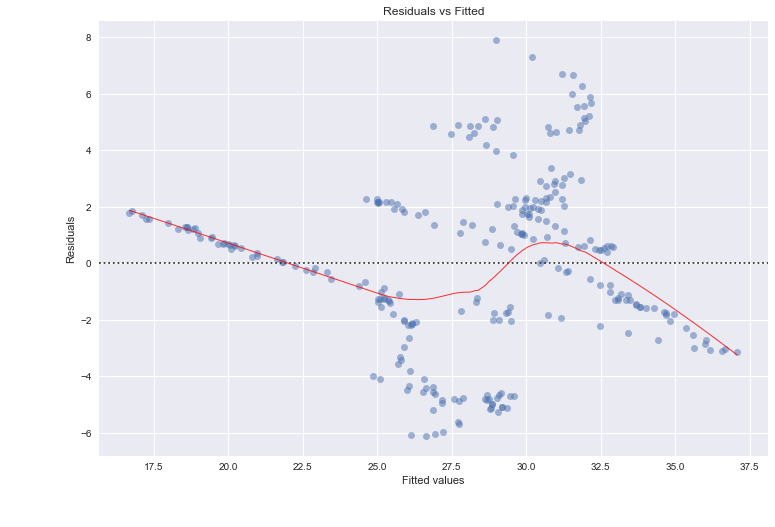

In [81]:
plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(8)
plot_lm_1.set_figwidth(12)

plot_lm_1.axes[0] = sns.residplot(model_fitted_y, 'CPI', data=keep, 
                          lowess=True, 
                          scatter_kws={'alpha': 0.5}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')

# annotations
abs_resid = model_abs_resid.sort_values(ascending=False)
abs_resid_top_3 = abs_resid[:3]

for i in abs_resid_top_3.index:
    plot_lm_1.axes[0].annotate(i, 
                               xy=(model_fitted_y[i], 
                                   model_residuals[i]));

# Interpretation: ?? Talk to Kulich

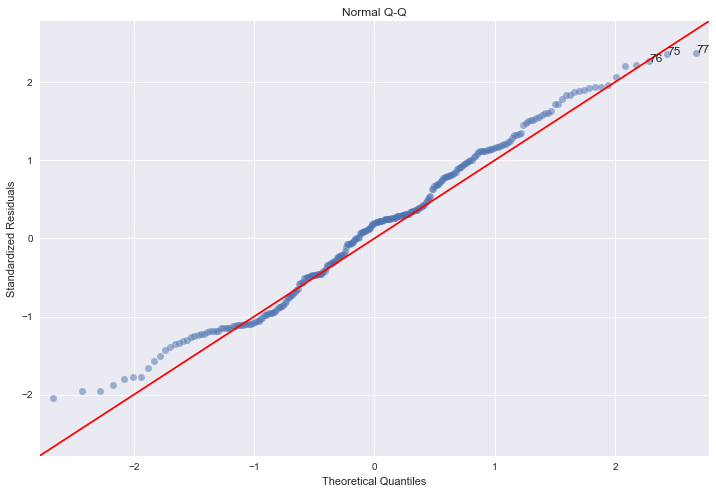

In [83]:
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)

plot_lm_2.set_figheight(8)
plot_lm_2.set_figwidth(12)

plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');

# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]

for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i, 
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));

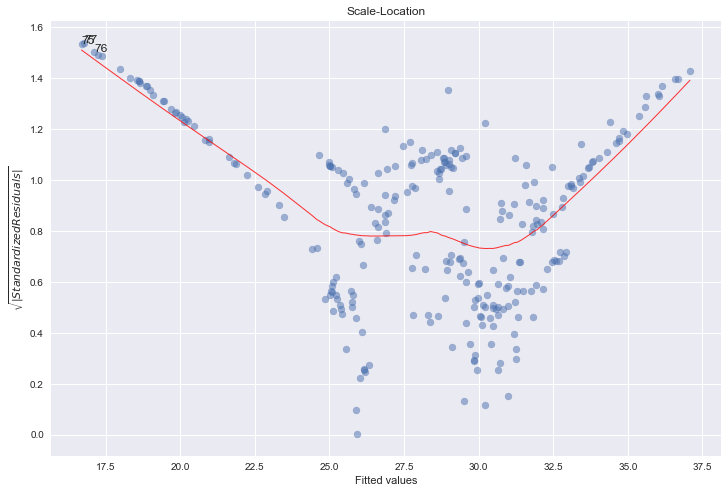

In [84]:
plot_lm_3 = plt.figure(3)
plot_lm_3.set_figheight(8)
plot_lm_3.set_figwidth(12)

plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_3.axes[0].set_title('Scale-Location')
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

# annotations
abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]

for i in abs_norm_resid_top_3:
    plot_lm_3.axes[0].annotate(i, 
                               xy=(model_fitted_y[i], 
                                   model_norm_residuals_abs_sqrt[i]));

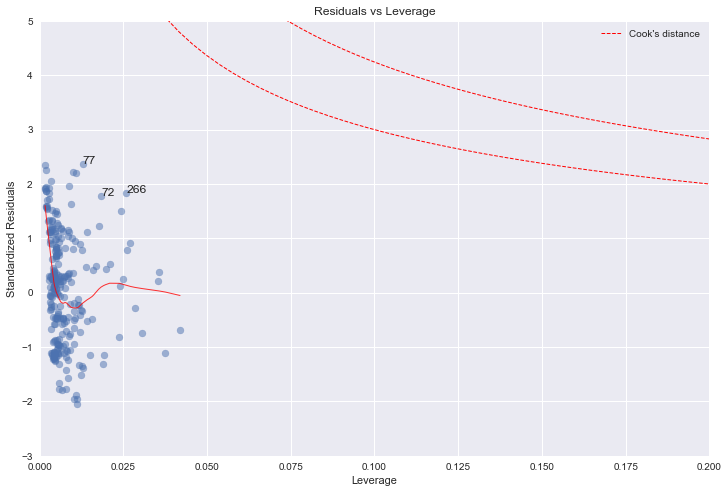

In [85]:
plot_lm_4 = plt.figure(4)
plot_lm_4.set_figheight(8)
plot_lm_4.set_figwidth(12)

plt.scatter(model_leverage, model_norm_residuals, alpha=0.5)
sns.regplot(model_leverage, model_norm_residuals, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_4.axes[0].set_xlim(0, 0.20)
plot_lm_4.axes[0].set_ylim(-3, 5)
plot_lm_4.axes[0].set_title('Residuals vs Leverage')
plot_lm_4.axes[0].set_xlabel('Leverage')
plot_lm_4.axes[0].set_ylabel('Standardized Residuals')

# annotations
leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]

for i in leverage_top_3:
    plot_lm_4.axes[0].annotate(i, 
                               xy=(model_leverage[i], 
                                   model_norm_residuals[i]))
    
# shenanigans for cook's distance contours
def graph(formula, x_range, label=None):
    x = x_range
    y = formula(x)
    plt.plot(x, y, label=label, lw=1, ls='--', color='red')

p = len(model_fit.params) # number of model parameters

graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x), 
      np.linspace(0.001, 0.200, 50), 
      'Cook\'s distance') # 0.5 line
graph(lambda x: np.sqrt((1 * p * (1 - x)) / x), 
      np.linspace(0.001, 0.200, 50)) # 1 line
plt.legend(loc='upper right');

# Comments
1994 inflation was higher in relation to S&P 500

In [87]:
keep.iloc[65:85]

,LVX,CPI,SP500,SP500_lag1,SP500_lag4
Rounded_Date,,,,,
1993-10-01,24.03,26.69,3.67,3.69,4.15
1993-11-01,24.91,26.69,3.60,3.67,4.10
1993-12-01,24.97,26.71,3.58,3.60,3.93
1994-01-01,25.18,26.64,3.55,3.58,3.69
1994-02-01,25.29,26.59,3.34,3.55,3.67
1994-03-01,25.67,26.63,3.17,3.34,3.60
1994-04-01,25.75,26.69,2.94,3.17,3.58
1994-05-01,25.75,26.70,2.94,2.94,3.55
1994-06-01,31.55,26.77,2.73,2.94,3.34


# Comments
redo model analysis for S&P 500 and LVX

In [89]:
keep = df.dropna()# S&P 500 model
formula = 'SP500 ~ SP500_lag1 + SP500_lag4 - 1' #remove the intercept
sp500_model = smf.ols(formula=formula, data=keep)
sp500_model.fit().summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  SP500   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.643e+05
Date:                Sun, 30 Sep 2018   Prob (F-statistic):               0.00
Time:                        11:15:25   Log-Likelihood:                 143.92
No. Observations:                 267   AIC:                            -283.8
Df Residuals:                     265   BIC:                            -276.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
SP500_lag1     1.0870      0.030     36.363      0.000       1.028       1.146
SP500_lag4    -0.0881      0.030     -2.943      0.004      -0.147      -0.029
==============================================================================
Omnibus:                        6.696   Durbin-Watson:                   1.478
Prob(Omnibus):                  0.035   Jarque-Bera (JB):               10.699
Skew:                           0.015   Prob(JB):                      0.00475
Kurtosis:                       3.980   Cond. No.                         34.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Comments
R-squared on SP 500 high coefficients one is positive and one is negative
TODO excel/table of all r-squared & coefficients for all three models and interpret cooeficients

In [91]:
keep = df.dropna() # lvx model
formula = 'LVX ~ SP500_lag1 + SP500_lag4 - 1' #remove the intercept
lvx_model = smf.ols(formula=formula, data=keep)
lvx_model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    LVX   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     326.9
Date:                Sun, 30 Sep 2018   Prob (F-statistic):           2.84e-72
Time:                        11:17:00   Log-Likelihood:                -1630.7
No. Observations:                 267   AIC:                             3265.
Df Residuals:                     265   BIC:                             3273.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
SP500_lag1    11.6963     23.024      0.508      0.612     -33.637      57.029
SP500_lag4    22.6609     23.044      0.983      0.326     -22.712      68.034
==============================================================================
Omnibus:                        0.332   Durbin-Watson:                   0.003
Prob(Omnibus):                  0.847   Jarque-Bera (JB):               26.015
Skew:                           0.084   Prob(JB):                     2.24e-06
Kurtosis:                       1.480   Cond. No.                         34.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Comments 
High coeficients, PValues are big
lvx is not coorelated with S&P 500 and CPI and thus a potential hedge